In [2]:
# prompt: a basic EDA for a dataset

import pandas as pd

# Load the dataset
df = pd.read_csv('../backend/uploads/DataCoSupplyChainDataset.csv', encoding='latin-1')

# Display the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset
print("\nDataset Info:")
df.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display the data types of each column
print("\nData Types:")
df.dtypes

FileNotFoundError: [Errno 2] No such file or directory: '../backend/uploads/DataCoSupplyChainDataset.csv'

In [4]:
# prompt: For numeric columns, identify outlier and missing value
df = df.drop(columns = ["Customer Id"])
# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

print("\nIdentifying outliers and missing values for numeric columns:")

for col in numeric_cols:
    print(f"\nAnalyzing column: {col}")

    # Missing values
    missing_count = df[col].isnull().sum()
    print(f"  Missing values: {missing_count}")

    # Outliers (using Z-score)
    # We'll calculate Z-scores and consider values with |Z-score| > 3 as outliers
    if missing_count == 0: # Avoid calculating z-score on columns with NaNs
        mean = df[col].mean()
        std = df[col].std()
        if std > 0: # Avoid division by zero
            z_scores = (df[col] - mean) / std
            outliers = df[(abs(z_scores) > 3)]
            print(f"  Potential outliers (Z-score > 3 or < -3): {len(outliers)}")
            # You might want to inspect these rows, e.g., outliers.head()
        else:
            print("  Cannot calculate Z-scores, standard deviation is zero.")
    else:
        print("  Skipping outlier detection for Z-score due to missing values.")

    # Outliers (using IQR)
    # We'll calculate the IQR and consider values outside 1.5 * IQR from Q1 and Q3 as outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"  Potential outliers (IQR method): {len(iqr_outliers)}")
    # You might want to inspect these rows, e.g., iqr_outliers.head()



Identifying outliers and missing values for numeric columns:

Analyzing column: Days for shipping (real)
  Missing values: 0
  Potential outliers (Z-score > 3 or < -3): 0
  Potential outliers (IQR method): 0

Analyzing column: Days for shipment (scheduled)
  Missing values: 0
  Potential outliers (Z-score > 3 or < -3): 0
  Potential outliers (IQR method): 0

Analyzing column: Benefit per order
  Missing values: 0
  Potential outliers (Z-score > 3 or < -3): 3608
  Potential outliers (IQR method): 18942

Analyzing column: Sales per customer
  Missing values: 0
  Potential outliers (Z-score > 3 or < -3): 477
  Potential outliers (IQR method): 1943

Analyzing column: Late_delivery_risk
  Missing values: 0
  Potential outliers (Z-score > 3 or < -3): 0
  Potential outliers (IQR method): 0

Analyzing column: Category Id
  Missing values: 0
  Potential outliers (Z-score > 3 or < -3): 0
  Potential outliers (IQR method): 0

Analyzing column: Customer Zipcode
  Missing values: 3
  Skipping outl

In [5]:
# prompt: remove all the Z-score > 3 outlier in numeric columns

from scipy.stats import zscore

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Remove outliers based on Z-score > 3
# Create a boolean mask to identify rows where ANY numeric column has a Z-score > 3
outlier_mask = (df[numeric_cols].apply(zscore).abs() > 3).any(axis=1)

# Filter the DataFrame to keep rows that are NOT outliers
df_cleaned = df[~outlier_mask].copy()

print(f"\nOriginal number of rows: {len(df)}")
print(f"Number of rows after removing Z-score outliers: {len(df_cleaned)}")

# You can now work with df_cleaned which has Z-score outliers removed from numeric columns


Original number of rows: 180519
Number of rows after removing Z-score outliers: 168326


In [6]:
# prompt: transform shipping date (DateOrders) into something I can process, maybe take it apart

# # Convert 'DateOrders' to datetime objects
df['DateOrders'] = pd.to_datetime(df['shipping date (DateOrders)'])

# Extract date and time components
df['ShippingYear'] = df['DateOrders'].dt.year
df['ShippingMonth'] = df['DateOrders'].dt.month
df['ShippingDay'] = df['DateOrders'].dt.day
df['ShippingHour'] = df['DateOrders'].dt.hour
df['ShippingWeekday'] = df['DateOrders'].dt.weekday # Monday=0, Sunday=6
df = df.drop(columns = ['shipping date (DateOrders)'])
df = df.drop(columns = ['DateOrders'])


In [7]:
# prompt: transform 'order date (DateOrders)' into year, month, day, hour, weekday and drop ti

# Convert 'order date (DateOrders)' to datetime objects
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

# Extract date and time components
df['OrderYear'] = df['order date (DateOrders)'].dt.year
df['OrderMonth'] = df['order date (DateOrders)'].dt.month
df['OrderDay'] = df['order date (DateOrders)'].dt.day
df['OrderHour'] = df['order date (DateOrders)'].dt.hour
df['OrderWeekday'] = df['order date (DateOrders)'].dt.weekday # Monday=0, Sunday=6

# Drop the original column
# df = df.drop(columns = ['order date (DateOrders)', 'DateOrders'])
df = df.drop(columns = ['order date (DateOrders)'])


In [8]:
# remove columns that have nothing to do with late
df = df.drop(columns = ["Customer Password", 'Customer Fname', 'Customer Lname', 'Customer Email', 'Product Image'])

In [10]:
# prompt: for all object columns, remove the unique value that only appears once

# Remove unique values that appear only once in object columns
object_cols_to_process = df.select_dtypes(include=['object']).columns

for col in object_cols_to_process:
    value_counts = df[col].value_counts()
    unique_values_once = value_counts[value_counts == 1].index.tolist()
    if unique_values_once:
        print(f"Removing unique values appearing once in column '{col}': {unique_values_once}")
        df = df[~df[col].isin(unique_values_once)].copy()

print("\nNumber of unique values for object columns after removal:")
object_cols_after_removal = df.select_dtypes(include=['object']).columns
for col in object_cols_after_removal:
    unique_count = df[col].nunique()
    print(f"  Column '{col}': {unique_count} unique values")

Removing unique values appearing once in column 'Customer State': ['91732']
Removing unique values appearing once in column 'Customer Street': ['229 Lost Canyon ', '8416 Emerald Dale ', '7581 Round Island', '9899 Silent Court ', '4981 Fallen Place ', '6076 Sleepy Manor ', '8460 Dewy Nook ', '921 Broad Chase ', '6332 Round Range ', '4788 Gentle Wynd ', '4320 Iron Highlands ', '7909 Amber View ', '9383 Jagged Front ', '6724 High Chase ', '2966 Round Ridge ', '9439 Blue Range ', '8055 Iron Ridge ', '379 Honey Maze ', '6714 Cozy Wynd ', '7471 Easy Edge ', '9099 Shady Round ', '2991 Round Hill ', '443 Jagged Lane ', '9765 Quaking Turnabout ', '4439 Colonial Vale', '2592 Colonial Pointe ', '3393 Crystal Port ', '1966 Broad Run ', '8893 Indian Swale ', '4462 Rocky Harbour', '6316 Wishing Rise ', '2407 Gentle Woods ', '9022 Lazy Bend ', '7581 Round Island ', '8263 Harvest Estates ', '2783 Foggy Mews ', '1840 Fallen Lane ', '2486 Silver Carrefour ', '97 Burning Landing ', '599 Clear Gardens ', 

In [12]:
# temporily remove columns with too many unique value

df = df.drop(columns = ['Customer Street', 'Order City', 'Order State'])



In [13]:
# Drop columns that might tell the answer

df = df.drop(columns = ['Late_delivery_risk', 'Delivery Status'])
# df = df.drop(columns = ['Days for shipment (scheduled)', 'Late_delivery_risk', 'Delivery Status', 'Shipping Mode'])

# df = df.drop(columns = ['Late_delivery_risk', 'Delivery Status', 'Shipping Mode'])

In [16]:
# Drop columns with too many missing value
df = df.drop(columns = ['Order Zipcode', 'Product Description'])

In [ ]:
# prompt: load the encoder and encoder the df
import joblib
# Load the saved encoder
loaded_encoder = joblib.load('./backend/model/one_hot_encoder.joblib')

# Select the object columns from the current state of df for encoding
# Ensure you select the same columns that were used for training the encoder
object_cols_to_encode_now = df.select_dtypes(include=['object']).columns

# Encode the selected object columns in the current DataFrame
encoded_data = loaded_encoder.transform(df[object_cols_to_encode_now])

# Convert the encoded data to a DataFrame
# Get the feature names from the encoder
encoded_feature_names = loaded_encoder.get_feature_names_out(object_cols_to_encode_now)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=df.index)

# Drop the original object columns from df
df_encoded = df.drop(columns=object_cols_to_encode_now)

# Concatenate the original DataFrame (without object columns) with the encoded DataFrame
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

print("\nDataFrame after loading encoder and applying encoding:")
print(df_encoded.head())
print("\nNumber of columns after re-encoding:", df_encoded.shape[1])
print("\nData types after re-encoding:")
df_encoded.dtypes


DataFrame after loading encoder and applying encoding:
   Days for shipping (real)  Days for shipment (scheduled)  Benefit per order  \
0                         3                              4          91.250000   
1                         5                              4        -249.089996   
2                         4                              4        -247.779999   
3                         3                              4          22.860001   
4                         2                              4         134.210007   

   Sales per customer  Category Id  Customer Zipcode  Department Id  \
0          314.640015           73             725.0              2   
1          311.359985           73             725.0              2   
2          309.720001           73           95125.0              2   
3          304.809998           73           90027.0              2   
4          298.250000           73             725.0              2   

    Latitude   Longitude  Orde

,0
Days for shipping (real),int64
Days for shipment (scheduled),int64
Benefit per order,float64
Sales per customer,float64
Category Id,int64
...,...
Product Name_insta-bed Neverflat Air Mattress,float64
Shipping Mode_First Class,float64
Shipping Mode_Same Day,float64
Shipping Mode_Second Class,float64


In [23]:
# prompt: set up two kind of X and Y, one for predict 'Days for shipping (real)', one for  'delay' make sure to remove them both from X

# X and Y for 'Days for shipping (real)' prediction
X_shipping_real = df.drop(columns=['Days for shipping (real)', 'delay']).copy()
y_shipping_real = df['Days for shipping (real)'].copy()

# X and Y for 'delay' prediction
X_delay = df.drop(columns=['Days for shipping (real)', 'delay']).copy()
y_delay = df['delay'].copy()

print("\nShape of X_shipping_real:", X_shipping_real.shape)
print("Shape of y_shipping_real:", y_shipping_real.shape)
print("Shape of X_delay:", X_delay.shape)
print("Shape of y_delay:", y_delay.shape)


Shape of X_shipping_real: (179965, 1033)
Shape of y_shipping_real: (179965,)
Shape of X_delay: (179965, 1033)
Shape of y_delay: (179965,)


In [24]:
# prompt: Train test split on X_delay

from sklearn.model_selection import train_test_split

# Perform train-test split for X_delay and y_delay
X_delay_train, X_delay_test, y_delay_train, y_delay_test = train_test_split(X_delay, y_delay, test_size=0.2, random_state=42, stratify=y_delay)

print("\nShape of X_delay_train:", X_delay_train.shape)
print("Shape of X_delay_test:", X_delay_test.shape)
print("Shape of y_delay_train:", y_delay_train.shape)
print("Shape of y_delay_test:", y_delay_test.shape)



Shape of X_delay_train: (143972, 1033)
Shape of X_delay_test: (35993, 1033)
Shape of y_delay_train: (143972,)
Shape of y_delay_test: (35993,)


# Classification

## XGBoost

In [ ]:
# prompt: set up a XGboost classifier with imputer and robust scaler to preduct y_delay. Fit the training data and give me the score on testing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Create a pipeline with Imputer, Scaler, and XGBoost Classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Use median for imputation as it's robust to outliers
    ('scaler', RobustScaler()), # RobustScaler is good for data with outliers
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)) # XGBoost Classifier
])

# Fit the pipeline to the training data
pipeline.fit(X_delay_train, y_delay_train)


In [1]:
# prompt: # Make predictions on the test data
# y_delay_pred = pipeline.predict(X_delay_test)
# # Evaluate the model
# accuracy = accuracy_score(y_delay_test, y_delay_pred)
# print(f"\nAccuracy on the test set: {accuracy}")
# show all the score, precision, recall f1 for both class

from sklearn.metrics import classification_report
# Make predictions on the test data
y_delay_pred = pipeline.predict(X_delay_test)
print("\nClassification Report on the test set:")
print(classification_report(y_delay_test, y_delay_pred))

NameError: name 'pipeline' is not defined


Feature Significance (sorted by importance):
Shipping Mode_First Class        0.351161
Shipping Mode_Second Class       0.132208
ShippingHour                     0.130610
Days for shipment (scheduled)    0.066885
ShippingDay                      0.036720
                                   ...   
Customer City_Longview           0.000000
Customer City_Los Angeles        0.000000
Customer City_Louisville         0.000000
Customer City_Loveland           0.000000
Customer City_Levittown          0.000000
Length: 1033, dtype: float32


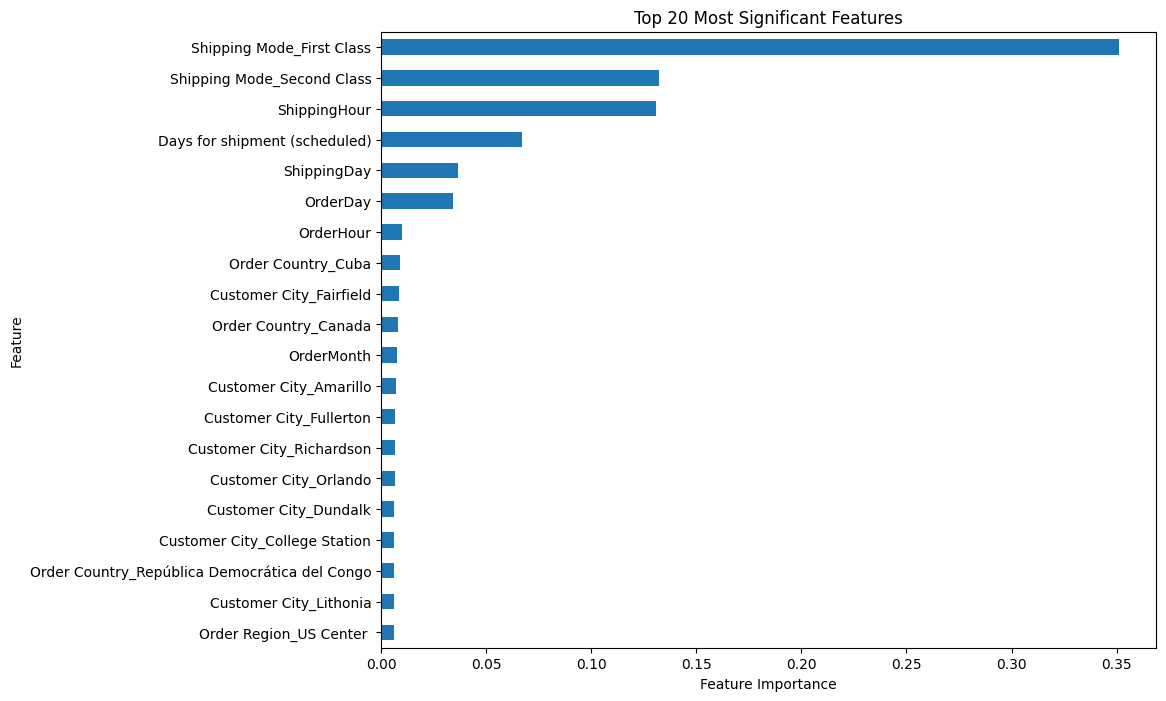

In [47]:
# prompt: check for which feature is most significant in this mode

# Get the XGBoost model from the pipeline
xgb_model = pipeline.named_steps['xgb']

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get feature names from the training data
feature_names = X_delay_train.columns

# Create a pandas Series for better visualization
feature_importances_series = pd.Series(feature_importances, index=feature_names)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Print the most significant features
print("\nFeature Significance (sorted by importance):")
print(sorted_feature_importances)

# You can also visualize the top features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sorted_feature_importances.head(20).plot(kind='barh')
plt.title('Top 20 Most Significant Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Invert axis to have the most important at the top
plt.show()

In [ ]:
# prompt: export this pipeline file and give me example usage

import joblib

# Export the pipeline to a file
pipeline_filename = './backend/model/delay_prediction_pipeline.joblib'
joblib.dump(pipeline, pipeline_filename)

print(f"\nPipeline exported to: {pipeline_filename}")



Pipeline exported to: /content/drive/MyDrive/MDS/delay_prediction_pipeline.joblib


In [ ]:
# prompt: how do I load this pipeline and use it

# Load the saved pipeline
loaded_pipeline = joblib.load('/content/drive/MyDrive/MDS/delay_prediction_pipeline.joblib')

# Now you can use the loaded_pipeline to make predictions on new data
# For example, if you have a new DataFrame called 'new_data' with the same columns as X_delay_train
# except for the target variable and other dropped columns:

# Example: Create some sample new data (replace with your actual new data)
# Make sure the columns and their order match the training data's columns
# Excluding 'Days for shipping (real)' and 'delay'
new_data = X_delay_test.head(5) # Using a small part of the test data as an example of 'new_data'

# Make predictions using the loaded pipeline
new_predictions = loaded_pipeline.predict(new_data)

print("\nPredictions on sample new data:")
new_predictions

# If you want the probability estimates
# new_probabilities = loaded_pipeline.predict_proba(new_data)
# print("\nProbability estimates on sample new data (for class 1 - delay):")
# print(new_probabilities[:, 1])


In [22]:
# prompt: cross validation for my xgboost mode

from sklearn.model_selection import cross_val_score

# Perform cross-validation on the pipeline
# Using 5 folds (cv=5) and 'accuracy' as the scoring metric
cv_scores = cross_val_score(pipeline, X_delay, y_delay, cv=5, scoring='accuracy')

print("\nCross-validation scores (Accuracy):")
print(cv_scores)

print(f"\nMean Cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of Cross-validation accuracy: {cv_scores.std():.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:05:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:07:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:08:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:10:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Cross-validation scores (Accuracy):
[0.99991665 0.99899981 1.         1.         1.        ]

Mean Cross-validation accuracy: 0.9998
Standard deviation of Cross-validation accuracy: 0.0004


# Regression

In [24]:
# prompt: train test split for # X and Y for 'Days for shipping (real)' prediction
# X_shipping_real = df.drop(columns=['Days for shipping (real)', 'delay']).copy()
# y_shipping_real = df['Days for shipping (real)'].copy()

X_shipping_real_train, X_shipping_real_test, y_shipping_real_train, y_shipping_real_test = train_test_split(X_shipping_real, y_shipping_real, test_size=0.2, random_state=42)

print("\nShape of X_shipping_real_train:", X_shipping_real_train.shape)
print("Shape of X_shipping_real_test:", X_shipping_real_test.shape)
print("Shape of y_shipping_real_train:", y_shipping_real_train.shape)
print("Shape of y_shipping_real_test:", y_shipping_real_test.shape)


Shape of X_shipping_real_train: (143972, 1032)
Shape of X_shipping_real_test: (35993, 1032)
Shape of y_shipping_real_train: (143972,)
Shape of y_shipping_real_test: (35993,)



Regression Model Performance for 'Days for shipping (real)':
Mean Squared Error (MSE): 0.0055
R-squared (R2): 0.9979

Feature Significance for 'Days for shipping (real)' prediction (sorted by importance):
Shipping Mode_Same Day           0.540512
Shipping Mode_First Class        0.212106
ShippingDay                      0.051311
OrderDay                         0.049699
Shipping Mode_Standard Class     0.019236
                                   ...   
Customer City_New Castle         0.000000
Customer City_New Brunswick      0.000000
Customer City_New Braunfels      0.000000
Customer City_Panorama City      0.000000
Customer City_North Hollywood    0.000000
Length: 1032, dtype: float32


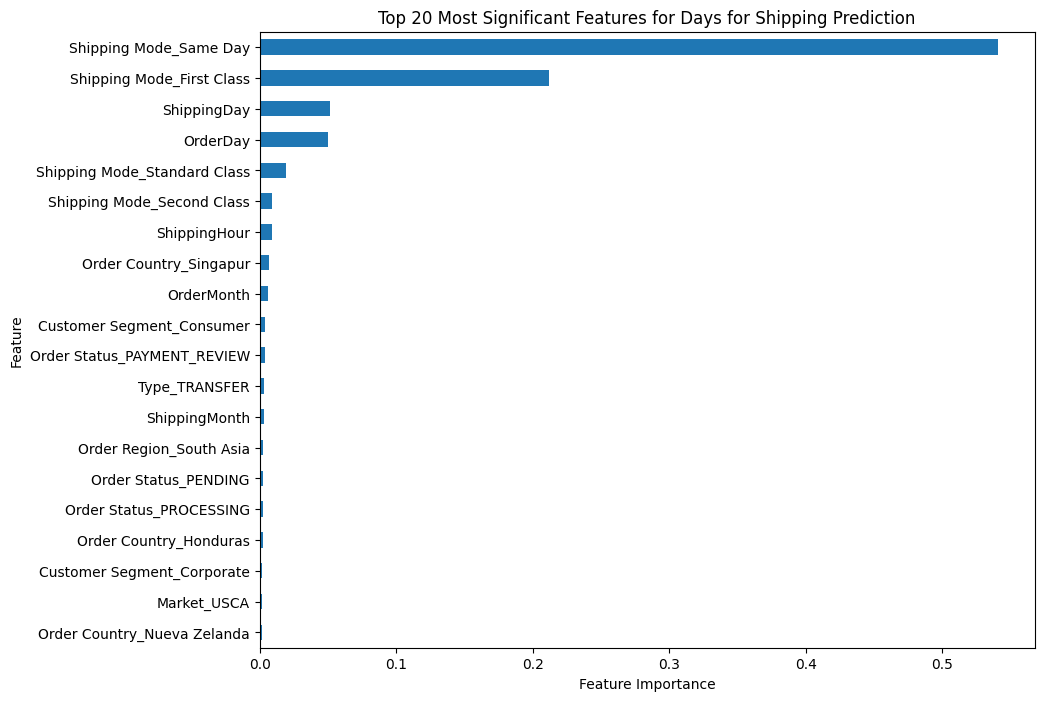

In [25]:
# prompt: xg regression model to predict
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a pipeline for regression with Imputer, Scaler, and XGBoost Regressor
pipeline_regression = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Use median for imputation
    ('scaler', RobustScaler()), # RobustScaler for potential outliers
    ('xgb_reg', XGBRegressor(objective='reg:squarederror', random_state=42)) # XGBoost Regressor
])

# Fit the regression pipeline to the training data for 'Days for shipping (real)'
pipeline_regression.fit(X_shipping_real_train, y_shipping_real_train)

# Make predictions on the test data
y_shipping_real_pred = pipeline_regression.predict(X_shipping_real_test)

# Evaluate the regression model
mse = mean_squared_error(y_shipping_real_test, y_shipping_real_pred)
r2 = r2_score(y_shipping_real_test, y_shipping_real_pred)

print(f"\nRegression Model Performance for 'Days for shipping (real)':")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Get the XGBoost Regressor model from the pipeline
xgb_reg_model = pipeline_regression.named_steps['xgb_reg']

# Get feature importances for the regression model
feature_importances_reg = xgb_reg_model.feature_importances_

# Get feature names from the training data
feature_names_reg = X_shipping_real_train.columns

# Create a pandas Series for better visualization
feature_importances_series_reg = pd.Series(feature_importances_reg, index=feature_names_reg)

# Sort feature importances in descending order
sorted_feature_importances_reg = feature_importances_series_reg.sort_values(ascending=False)

# Print the most significant features for regression
print("\nFeature Significance for 'Days for shipping (real)' prediction (sorted by importance):")
print(sorted_feature_importances_reg)

# Visualize the top features for regression
plt.figure(figsize=(10, 8))
sorted_feature_importances_reg.head(20).plot(kind='barh')
plt.title('Top 20 Most Significant Features for Days for Shipping Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Invert axis to have the most important at the top
plt.show()



Regression Model Performance:
Mean Squared Error (MSE): 0.01
R-squared (R2): 1.00


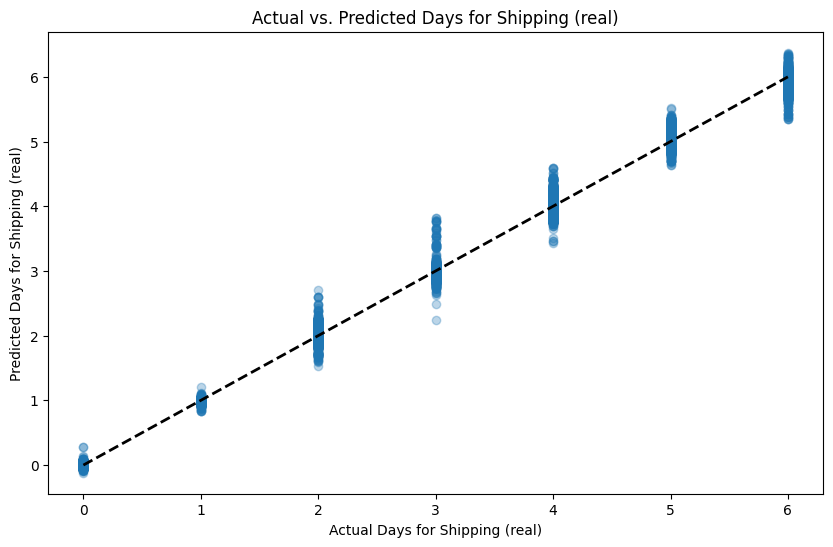

In [26]:
# Make predictions on the test data
y_shipping_real_pred = pipeline_regression.predict(X_shipping_real_test)

# Evaluate the regression model
mse = mean_squared_error(y_shipping_real_test, y_shipping_real_pred)
r2 = r2_score(y_shipping_real_test, y_shipping_real_pred)

print("\nRegression Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Optional: Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_shipping_real_test, y_shipping_real_pred, alpha=0.3)
plt.xlabel("Actual Days for Shipping (real)")
plt.ylabel("Predicted Days for Shipping (real)")
plt.title("Actual vs. Predicted Days for Shipping (real)")
plt.plot([y_shipping_real_test.min(), y_shipping_real_test.max()], [y_shipping_real_test.min(), y_shipping_real_test.max()], 'k--', lw=2) # Add a perfect prediction line
plt.show()